In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/test.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/data_description.txt


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split,cross_val_score

In [3]:
data = pd.read_csv('../input/home-data-for-ml-course/train.csv',index_col='Id')
test_data = pd.read_csv('../input/home-data-for-ml-course/test.csv',index_col='Id')

data.dropna(subset=['SalePrice'],axis=0,inplace=True)
y = data.SalePrice
data.drop(['SalePrice'],axis=1,inplace=True)

full_X_train,full_X_valid,y_train,y_valid = train_test_split(data,y,train_size=0.8,test_size=0.2)

categorical_cols= [ccn for ccn in full_X_train.columns if (full_X_train[ccn].nunique() < 10) and 
                   (full_X_train[ccn].dtype=='object')]

num_cols= [nm for nm in full_X_train.columns if full_X_train[nm].dtype in ['int64','float64']]

my_cols= categorical_cols+num_cols
X_train = full_X_train[my_cols]
X_valid = full_X_valid[my_cols]
X_test = test_data[my_cols]

In [4]:
numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='constant')),
                                         ('OH_encoder',OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(transformers=[('num_col',numerical_transformer,num_cols),
                                               ('cat_col',categorical_transformer,categorical_cols)])


def get_score(n_es):
    pipe_model= Pipeline(steps=[('prepro',preprocessor),
                           ('ran_for',RandomForestRegressor(n_estimators=n_es))])
    
    scores = -1 * cross_val_score(pipe_model,pd.concat([X_train,X_valid]),pd.concat([y_train,y_valid]),
                                 cv=5,
                                 scoring='neg_mean_absolute_error')
    return scores.mean()


results={}
for i in range(1,9):
    results[50*i]=get_score(50*i)
    
results


{50: 18039.879095890414,
 100: 17739.860219178085,
 150: 17841.915264840183,
 200: 17904.729208904108,
 250: 17793.217569863013,
 300: 17777.563146118722,
 350: 17725.896403131115,
 400: 17782.97896232876}

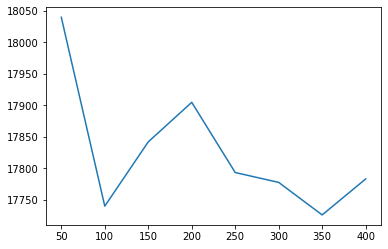

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()),list(results.values()))

In [6]:
pipe_model1= Pipeline(steps=[('prepro',preprocessor),
                           ('ran_for',RandomForestRegressor(n_estimators=350))])
pipe_model1.fit(pd.concat([X_train,X_valid]),pd.concat([y_train,y_valid]))
pred = pipe_model1.predict(X_valid)
print(f'MAE: {mean_absolute_error(pred,y_valid)}')


MAE: 7700.35329745597


In [7]:
pred1 = pipe_model1.predict(X_test)

subm = pd.DataFrame({'Id':X_test.index,
                    'SalePrice':pred1})

subm.to_csv('submission.csv',index=False)